# 我们利用最简单的回归模型看一下上证综指的婴儿底到底在哪里。

## 基本结论：
- 在2016年12月24日平均的预期股指底部在2694点，50%的概率2694是历史最低点。
- 在2016年底，出现比2048更低的最低值的概率有15%。但是同样有15%的概率，股指是会一直大于3340。

## 分析模型假设：
- 股指是按照指数增长,也就是 y=e^x。这个假定似乎对于日本不成立，但是相信只要中国的GDP按照指数增长，股指也应该类似按照指数增长。
- 最底部的数值是相对稳定的，而最大值是变化更大的。所以本文的模型集中分析股指最底部。

## 下面是具体的模型分析：
- 用Jupyter运行，可以下载Anaconda Python安装后就有Jupyter，安装几个包就可以了。
- 

In [71]:
import pandas.io.data as web
import datetime
import pandas as pd
import scipy
import numpy as np 
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
%matplotlib inline

In [72]:

start = datetime.datetime(1992, 8, 12)
end = datetime.datetime(2016, 5, 20)

# 用下面的代码重新从yahoo抽取指数价格。
# If you want to run this notebook at your local instance, uncomment those lines of code and fetch the latest index from Yahoo again.
# Refer to:  http://pandas.pydata.org/pandas-docs/stable/remote_data.html
'''
shanghai = web.DataReader("000001.SS", 'yahoo', start, end)
shanghai.head()
shanghai.to_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
'''

# I saved and reloaded from this location as a cache for my testing purpose.
shanghai = pd.DataFrame.from_csv('C:\qduan\Stanmo\stock_minima\shanghai_index_1992_2016.csv')
#print(shanghai.count())


In [73]:
# shanghai.head()

这里我们将把日期改成从开始的1992年开始到每一天的间隔天数"days"。然后我们可以简单看一下下载的数据结构，基本上世界上所有的股票都是监控这几个指标，其中我们将重点关注最低价格"Low"。

In [74]:

sh = shanghai.copy()
sh['date1'] = shanghai.index
#http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
sh['days'] = sh['date1'].apply(lambda x:  (x-start).days)
sh.head()

,Open,High,Low,Close,Volume,Adj Close,date1,days
Date,,,,,,,,
1992-08-12,781.21,781.21,781.21,781.21,0,781.21,1992-08-12,0
1992-08-13,850.94,850.94,850.94,850.94,0,850.94,1992-08-13,1
1992-08-14,858.38,858.38,858.38,858.38,0,858.38,1992-08-14,2
1992-08-17,939.46,939.46,939.46,939.46,0,939.46,1992-08-17,5
1992-08-18,933.44,933.44,933.44,933.44,0,933.44,1992-08-18,6


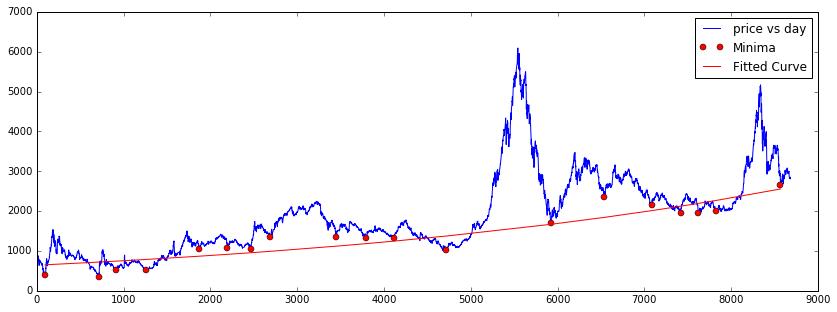

In [75]:

x_all = sh['days'].values
y_all = sh['Low'].values

# http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.signal.argrelextrema.html
from scipy.signal import argrelextrema
local_min_ix =  argrelextrema(y_all, np.less,   order=100)

x_minima=x_all[local_min_ix]
y_minima=y_all[local_min_ix]

def exp_func(x, a, b, c):
    return a * np.exp(b * x)
popt_minima, pcov_minima = curve_fit(exp_func, x_minima, y_minima, p0=[ 5.69396441e+02,   1.93941219e-04,   2.25849076e+02])

plt.figure(figsize=(14,5))
plt.plot(x_all, y_all, 'b-', label="price vs day") 
plt.plot(x_minima, y_minima, 'ro', label="Minima") 
plt.plot(x_minima, exp_func(x_minima, *popt_minima), 'r-', label="Fitted Curve")
plt.legend()
plt.show()



In [76]:
x_minima

array([  97,  716,  909, 1258, 1868, 2196, 2470, 2693, 3450, 3796, 4115,
       4716, 5928, 6536, 7085, 7418, 7624, 7831, 8569], dtype=int64)

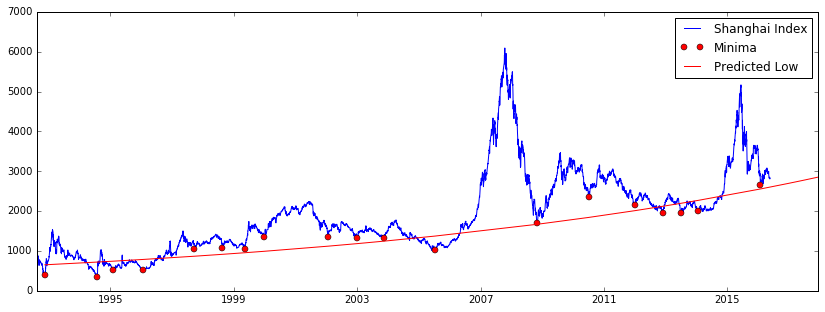

In [77]:
'''from datetime import datetime, timedelta

def add_start_date(a):
    days_add = int(a[0]) 
    print(start)
    print(days_add)
    # return datetime(1992, 8, 12)  +  timedelta(days=1) 
    return np.datetime64('1992-08-12') + np.timedelta64(days_add,'D') 

x_minima_date = np.apply_along_axis(add_start_date, 0, x_minima)
x_minima_date
'''
df = pd.DataFrame({'days': x_minima, 'predicted_low':exp_func(x_minima, *popt_minima) })
predicted_df = pd.merge(sh, df, on=['days','days'])

new_day = 8900
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 
new_day = 9060
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 
new_day = 9250
predicted_df.loc[start+datetime.timedelta(days=new_day)] =[-1, -1, -1, -1, 0, -1,  start+datetime.timedelta(days=new_day), new_day, exp_func(new_day, *popt_minima)]  # ['predicted_low'] 

plt.figure(figsize=(14,5))
plt.plot(sh['date1'].values, y_all, 'b-', label="Shanghai Index") 
plt.plot(predicted_df[predicted_df.date1<=end]['date1'].values, predicted_df[predicted_df.date1<=end]['Low'].values, 'ro', label="Minima") 
plt.plot(predicted_df['date1'].values, predicted_df['predicted_low'].values, 'r-', label="Predicted Low")
plt.legend()
plt.show()


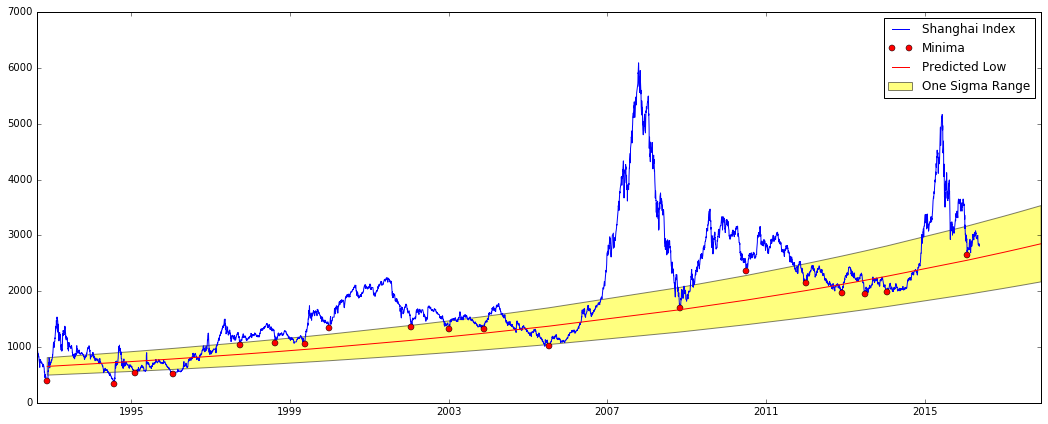

In [78]:
x_extended=np.append(  x_all[local_min_ix], [8900, 9000, 9100] )

# Generate some data for this demonstration.
data =( exp_func(x_minima, *popt_minima)-y_minima ) / exp_func(x_minima, *popt_minima)
# Fit a normal distribution to the data:
mu, std = scipy.stats.norm.fit(data)

# the 1 sigma upper and lower analytic population bounds
#lower_bound = exp_func(x_extended, *popt_minima)*(1-std)
#upper_bound = exp_func(x_extended, *popt_minima)*(1+std)

predicted_df['lower_bound'] = predicted_df['predicted_low'].values *(1-std)
predicted_df['upper_bound'] = predicted_df['predicted_low'].values *(1+std)

plt.figure(figsize=(18,7))
plt.plot(sh['date1'].values, y_all, 'b-', label="Shanghai Index") 
plt.plot(predicted_df[predicted_df.date1<=end]['date1'].values, predicted_df[predicted_df.date1<=end]['Low'].values, 'ro', label="Minima") 
plt.plot(predicted_df['date1'].values, predicted_df['predicted_low'].values, 'r-', label="Predicted Low")

plt.fill_between(predicted_df['date1'].values, 
                 predicted_df['lower_bound'].values, 
                 predicted_df['upper_bound'].values, 
                 facecolor='yellow', alpha=0.5, label='One Sigma Range')
plt.legend()
plt.show()

 

In [79]:
# Now we check a few statistics and first of all those are the data of previous chart:
predicted_df[['date1','Low', 'predicted_low','lower_bound','upper_bound']]

,date1,Low,predicted_low,lower_bound,upper_bound
0,1992-11-17,393.52,652.277070,495.942278,808.611862
1,1994-07-29,333.92,720.693024,547.960608,893.425439
2,1995-02-07,532.49,743.458345,565.269641,921.647049
3,1996-01-22,516.46,786.466071,597.969471,974.962670
4,1997-09-23,1041.97,867.697545,659.731757,1075.663334
5,1998-08-17,1070.41,914.791498,695.538446,1134.044550
6,1999-05-18,1059.87,956.085868,726.935570,1185.236166
7,1999-12-27,1345.35,991.066166,753.531950,1228.600383
8,2002-01-22,1358.69,1119.639539,851.289443,1387.989635
9,2003-01-03,1319.87,1183.836251,900.099780,1467.572721


现在我们来检查几个简单的统计值。根据上面表格，在2016年底12月24日平均的预期股指底部在2694点，基本是五五开的概率。有50%的概率会出现低于这个值的情况，也有50%的可能永远都高于这个值。

其他几个统计情况。首先看一下隔多久出现一次最低值。我们先看一下一年多少个交易日。
[Some answers from web](http://zhidao.baidu.com/question/347142653.html)
2001年至2010年十年间年平均交易日是240.8天。2010年的交易日是242天。不过由于周末与年的频率不一致，所以每年可能会由1天左右的上下浮动，所以比较准确的说法是(241±1)天。。

根据下面的计算，大概最小的是193个交易日，相隔最久的是1212个交易日，也就是5年里面一个最低值。5年内一直不出现最低值，应该就是传说中的牛市了吧。



In [80]:
# Identify the interval of each minima
print(np.diff(x_minima))
print(np.amin(np.diff(x_minima)))
print(np.amax(np.diff(x_minima)))

[ 619  193  349  610  328  274  223  757  346  319  601 1212  608  549  333
  206  207  738]
193
1212


一个值如果低于1倍的Sigma，出现的概率是多少呢？大概是这个数：

In [81]:
print(scipy.stats.norm(mu, std).cdf(mu-std))
print(scipy.stats.norm(mu, std).cdf(mu+std))


0.158655253931
0.841344746069


也就是说在2016年底，出现比2048更低的最低值的概率有15%。但是同样有15%的概率，股指是会一直大于3340。

In [82]:
## Then we know the expected low end of shanghai index as: 
print(exp_func(8700, *popt_minima)) 


2609.02474536


下面我们来看看完整股指的回归测试结果。

In [83]:
print(popt_minima[1])
print(np.exp(240.8*popt_minima[1]))

0.000161137085168
1.03956443207


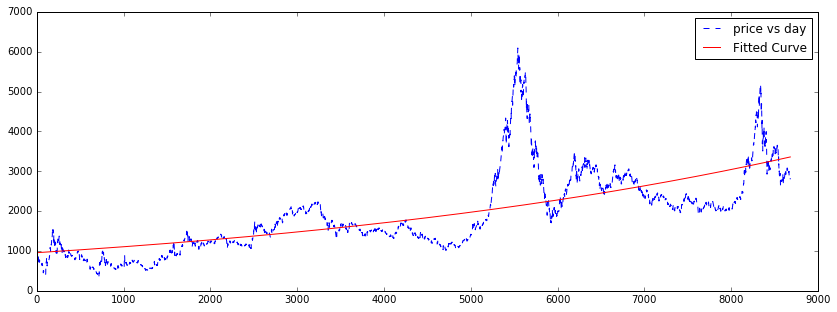

In [84]:
'''import random
rows = random.sample(sh.index, 30)
rows.sort()
sh_600 = sh.ix[rows]
'''

# Now use all data
#sh_600 =  


# print(x1.shape)

def exp_func(x, a, b, c):
    return a * np.exp(b * x)  
# p0=[100, 0.001, 900])
# ([  5.69396441e+02,   1.93941219e-04,   2.25849076e+02])
popt_all, pcov_all = curve_fit(exp_func, x_all, y_all, p0=[ 2.28786762e+04,   1.64695236e-05,  -2.23512090e+04])
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,5))
plt.plot(x_all, y_all, 'b--', label="price vs day") 
plt.plot(x_all, exp_func(x_all, *popt_all), 'r-', label="Fitted Curve")
plt.legend()
plt.show()
